## Modelo para predecir la demanda de los taxis amarillos de Manhattan, NY.

#### Importación de librerías

In [35]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.linear_model import LinearRegression
from sklearn import tree
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


#### Cargamos nuestro csv

In [36]:
taxi_df = pd.read_csv('Taxis_2023_reducido.csv')

In [37]:
# Exploración de los datos
print(taxi_df.head())  # Muestra las primeras filas del DataFrame para entender la estructura

   PULocationID    Borough                          Zone service_zone  \
0           170  Manhattan                   Murray Hill  Yellow Zone   
1           140  Manhattan               Lenox Hill East  Yellow Zone   
2           186  Manhattan  Penn Station/Madison Sq West  Yellow Zone   
3           142  Manhattan           Lincoln Square East  Yellow Zone   
4           239  Manhattan         Upper West Side South  Yellow Zone   

   passenger_count  trip_distance  DOLocationID  total_amount date_pickup  \
0              2.0           4.09            87         34.22  2023-01-26   
1              1.0           1.71           233         17.16  2023-06-16   
2              1.0           1.50           137         22.65  2023-01-15   
3              1.0           0.49           142         11.20  2023-04-11   
4              1.0           0.88           239         13.22  2023-01-26   

  time_pickup date_dropoff time_dropoff  
0    22:17:52   2023-01-26     22:41:59  
1    21:35:55 

#### Realizamos las transformaciones necesarias

In [38]:
#Obtenemos mes, dias, horas y dia de la semana
taxi_df['month'] = pd.DatetimeIndex(taxi_df['date_pickup']).month
taxi_df['dayofweek'] = pd.DatetimeIndex(taxi_df['date_pickup']).dayofweek
taxi_df['hour'] = pd.DatetimeIndex(taxi_df['time_pickup']).hour

#### Analizamos la demanda actual (2023)

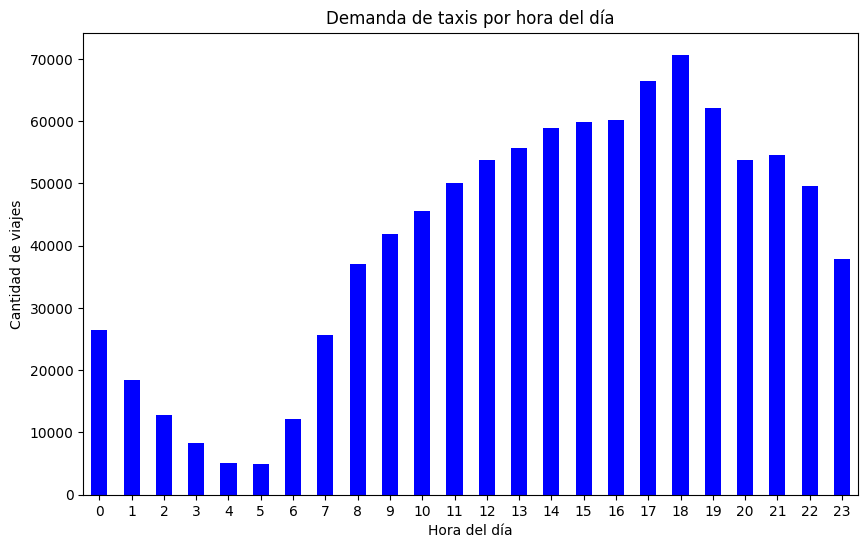

In [39]:
# Convertir las columnas de fecha y hora a formato datetime
taxi_df['date_pickup'] = pd.to_datetime(taxi_df['date_pickup'])
taxi_df['time_pickup'] = pd.to_datetime(taxi_df['time_pickup'])

# Crear una nueva columna para la fecha y hora completa
taxi_df['datetime_pickup'] = taxi_df['date_pickup'] + pd.to_timedelta(taxi_df['time_pickup'].dt.hour, unit='H')

# Agrupar los datos por hora y contar la cantidad de viajes
demand_by_hour = taxi_df.groupby(taxi_df['datetime_pickup'].dt.hour)['passenger_count'].count()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
demand_by_hour.plot(kind='bar', color='blue')

# Personalizar el gráfico
plt.title('Demanda de taxis por hora del día')
plt.xlabel('Hora del día')
plt.ylabel('Cantidad de viajes')
plt.xticks(rotation=0)

# Mostrar el gráfico
plt.show()

Se puede observar que el horario del día con mayor cantidad de de viajes son horarios de la tarde alcanzando su pico a las 18hs

#### Visualizamos la matriz de correlación y utilizamos las que mas correlación tengan

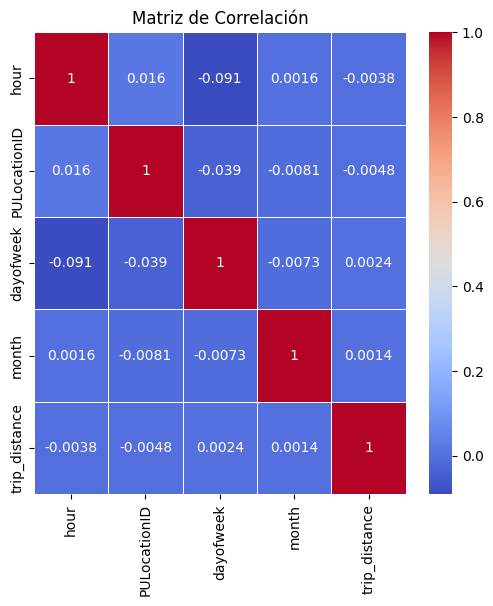

In [40]:
# Subconjunto de las columnas que quieres analizar
columnas_de_interes = [
    'hour',
    'PULocationID',
	'dayofweek',
    'month',
    'trip_distance'
]

# Crear un DataFrame que contenga solo estas columnas
df_subset = taxi_df[columnas_de_interes]

# Calcular la matriz de correlación
correlation_matrix = df_subset.corr()

# Crear un mapa de calor de la matriz de correlación
plt.figure(figsize=(6, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Matriz de Correlación')
plt.show()

### Agrupamos los datos por destino, hora y día, calculamos la demanda

In [41]:
#Agrupando por localizacion y tiempo
taxi_df = taxi_df.groupby(['hour','PULocationID','dayofweek']).size().reset_index(name='demanda')

In [42]:
#Creamos el porcentaje de Demanda
taxi_df['demanda'] = taxi_df['demanda'].apply(lambda x :  (x / taxi_df['demanda'].max()))
taxi_df['demanda'] = round(taxi_df['demanda']*100,2)

##### Observamos cuando hay mayor demanda

In [43]:
top = taxi_df.sort_values(by='demanda', ascending=False)
top.head()

,hour,PULocationID,dayofweek,demanda
7522,18,161,3,100.00
7521,18,161,2,99.54
7520,18,161,1,98.84
7941,19,161,2,93.28
489,1,79,6,92.12


El ID con mayor demanda al que van los pasajeros corresponde a Manhattan Midtown Center

In [44]:
top.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9803 entries, 7522 to 0
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   hour          9803 non-null   int32  
 1   PULocationID  9803 non-null   int64  
 2   dayofweek     9803 non-null   int32  
 3   demanda       9803 non-null   float64
dtypes: float64(1), int32(2), int64(1)
memory usage: 306.3 KB


## Comenzamos a crear el modelo de regresión lineal

In [45]:
# Seleccionar las características (X) y la variable objetivo (y)
features = ['PULocationID', 'dayofweek', 'hour']
target = 'demanda'

In [47]:
taxi_df.to_csv("taxi_ML.csv", index=False)

##### Definimos los ejes

In [48]:
X = taxi_df[features]
y = taxi_df[target]

In [49]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [51]:
# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

In [52]:
from sklearn import metrics

print ('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print ('MSE:', metrics.mean_squared_error(y_test, y_pred))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print ('R2:', metrics.r2_score(y_test, y_pred))


MAE: 9.676774603344573
MSE: 177.82583878382542
RMSE: 13.335135499267542
R2: 0.13708059708306186


In [53]:
def modelo_reg (y, y_pred):
    plt.figure (figsize=(12, 6))

#  Displot   
    plt.subplot (1, 2, 2)
    sns.distplot (y, hist = False, color = "r", label = "Valor real")
    sns.distplot (y_pred, hist = False, color = "b", label = "Predicciones del modelo", axlabel="Distribucion")
    plt.legend()
    plt.show()

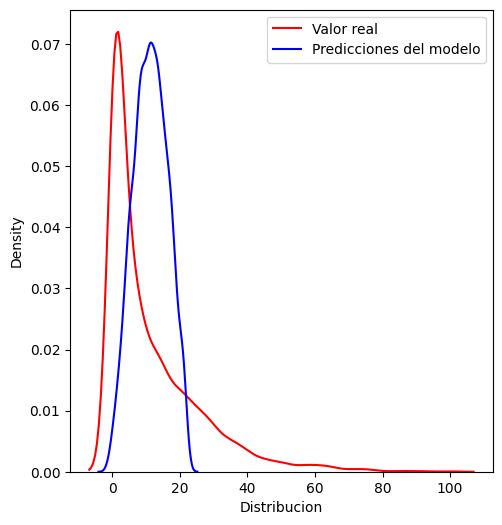

In [54]:
modelo_reg (y_train, model.predict (X_train))

Podemos observar que el modelo de regresión lineal no fué el más optimo para crear nuestro modelo de predicción por lo que usaremos otros modelos, se elige Random Forest la cuál es una opción más flexible que puede manejar relaciones no lineales y complejas entre las variables.

## Random forest

In [55]:
# Se dividen los datos en características (X) y etiquetas (y) en conjuntos de entrenamiento (X_train, y_train) y prueba (X_test, y_test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
#Se crea una instancia del modelo RandomForestRegressor
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)

RandomForestRegressor()

In [57]:
#Se utilizan las características del conjunto de prueba (X_test) para hacer predicciones
predictions = model_rf.predict(X_test)

In [58]:
mse = mean_squared_error(y_test, predictions)

In [59]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [60]:
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('R2:', r2)

MAE: 1.6757594084650689
MSE: 8.309405504018358
RMSE: 2.882603945050093
R2: 0.9596776976554071


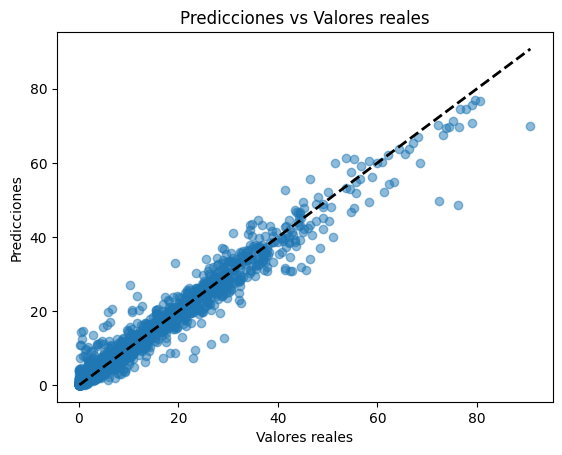

In [61]:
# Graficar las predicciones versus los valores reales
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores reales')
plt.show()

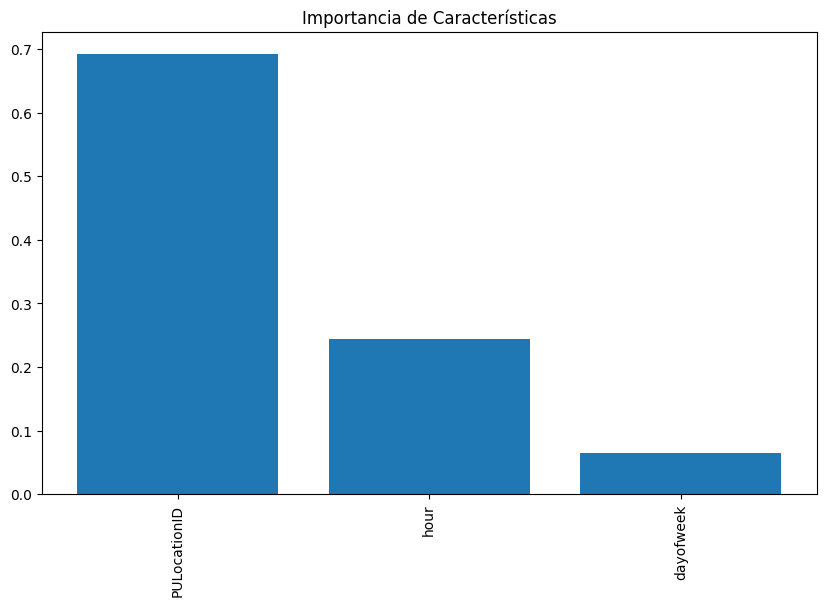

In [62]:
importances = model_rf.feature_importances_
feature_names = X_train.columns  # Asegúrate de que los nombres de las características coincidan con tus datos
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.title("Importancia de Características")
plt.show()

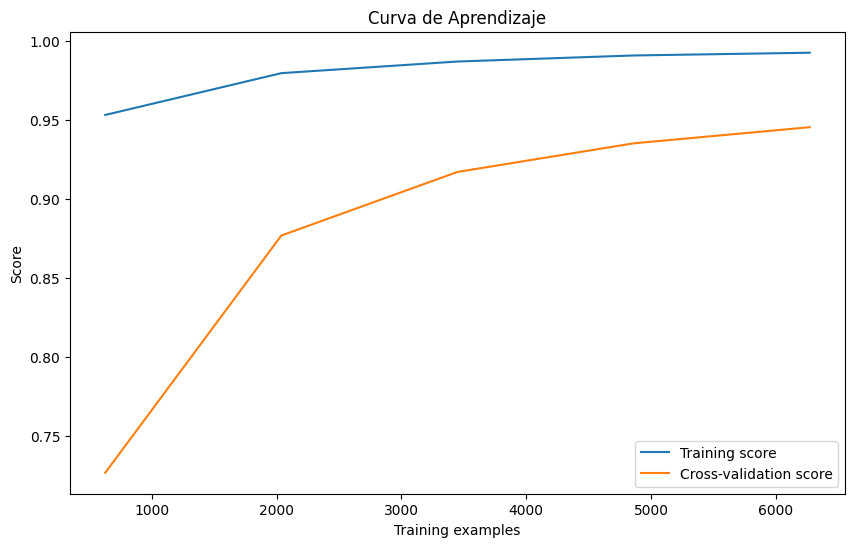

In [63]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(model_rf, X_train, y_train, cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("Curva de Aprendizaje")
plt.show()

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

### Realizamos un modelo XGBRegressor 

In [65]:
#Creamos el modelo
model_xgb = XGBRegressor(n_estimators=100, max_depth=10, random_state=42)

In [66]:
# Entrenamos el modelo
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [67]:
# Realizar predicciones en el conjunto de entrenamiento
y_pred_xgb = model_xgb.predict(X_test)

In [68]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
r2_xgb = r2_score(y_test, y_pred_xgb)

print('MAE (XGBoost):', mae_xgb)
print('MSE (XGBoost):', mse_xgb)
print('RMSE (XGBoost):', rmse_xgb)
print('R² (XGBoost):', r2_xgb)

MAE (XGBoost): 1.3686071392051091
MSE (XGBoost): 5.888335278538551
RMSE (XGBoost): 2.4265892274009935
R² (XGBoost): 0.9714262066891856


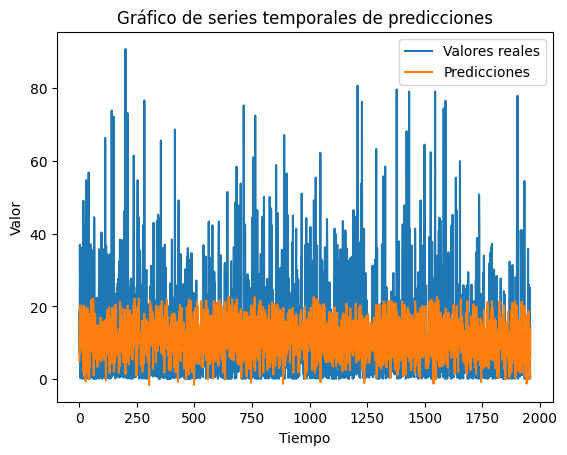

In [70]:
plt.plot(range(len(y_test)), y_test, label="Valores reales")
plt.plot(range(len(y_test)), y_pred, label="Predicciones")
plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.title("Gráfico de series temporales de predicciones")
plt.legend()
plt.show()

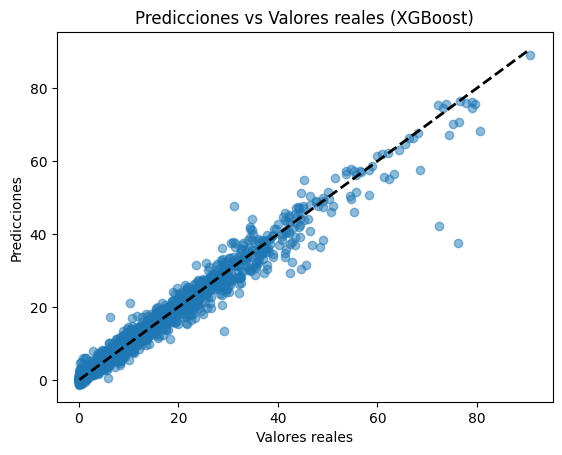

In [71]:
# Graficar las predicciones versus los valores reales
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores reales (XGBoost)')
plt.show()

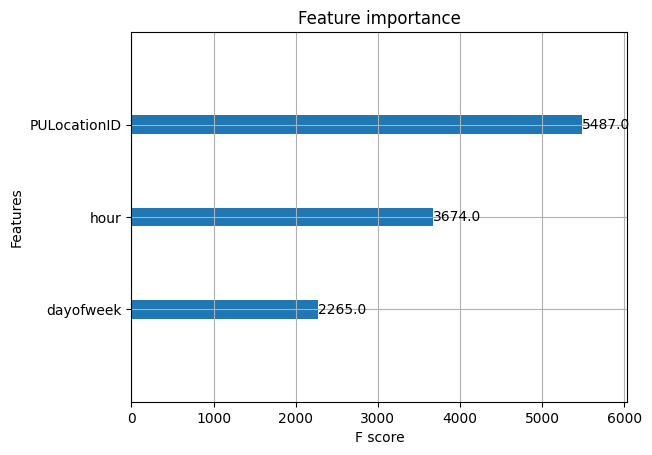

In [72]:
from xgboost import plot_importance

plot_importance(model_xgb, max_num_features=10) 
plt.show()

In [73]:
# Guardar el modelo en un archivo
model_xgb.save_model('xgb_model.model')

In [74]:
# Realizar predicciones en el conjunto de prueba
y_pred_xgb = model_xgb.predict(X_test)

# Imprimir las predicciones
print('Predicciones (XGBoost):', y_pred_xgb)

Predicciones (XGBoost): [19.46637     6.0292277  39.605587   ... 29.194994    1.8114666
  0.17499992]


Los modelos que mejor resultados pudimos obtener es el modelo XGBRegressor y el Random forest 